# Variational Autoencoder

This notebook demonstrates the workflow for building and training a Variational Autoencoder (VAE) using PyTorch with the MNIST dataset. This notebook will walk through the key steps, including data preparation, model definition, training, and evaluation, providing a comprehensive guide to implementing VAEs for unsupervised learning tasks on handwritten digit images.
> Generated by ChatGPT

***

## Loading Libraries

Library | Version | Channel
--- | --- | ---
NumPy | 1.26.4 | default
PyTorch | 2.2.2 | pytorch
Torchvision | 0.17.2 | pytorch
Tensorboard | / | conda-forge
tqdm | / | conda-forge

In [29]:
# Built-in libraries
from dataclasses import dataclass
from datetime import datetime

# Third-party libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm import tqdm

## Hyperparameters

In [30]:
# Batch size
batch_size = 128  # Power of 2 is optimized in many libraries

# Model architecture
size_input = 784
size_hidden = 512
size_latent = 2

# Optimizer
learning_rate = 1e-3
weight_decay = 1e-2

# Training
num_epochs = 50
epochs = 15

### Device Specification

The CUDA architecture from NVIDIA enables high-performance parallel computing on GPUs, optimizing tasks through concurrent execution and accelerating applications like deep learning and scientific simulations.
> Generated by ChatGPT

In [31]:
## Established the type of device used for model processing
device = "cuda" if torch.cuda.is_available() else "cpu"
cuda = True if device == "cuda" else False

## Loading Data

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset is a widely-used benchmark in machine learning, consisting of 70,000 images of handwritten digits from 0 to 9. Each image is a 28x28 grayscale pixel grid. Due to its simplicity and well-structured format, MNIST serves as an excellent starting point for developing and testing machine learning models, particularly in the field of image recognition and classification
> Generated by ChatGPT

### Data Transformation

For the model to be able to process the MNIST data, the data has to be transformed into a format that is understandable for our model. The following steps are applied to the data:

1. `v2.ToImage()` - Converts the tensor to an image format
2. `v2.toDtype()` - Converts the img to a floating point tensor
3. `v2.Lambda()` - Zero centers (normalization) the data and flattens it afterward for 1-dimensional input

In [32]:
img_transform = v2.Compose(
    [
        v2.ToImage(),  # Converts tensor to img
        v2.ToDtype(torch.float32, scale=True),  # Converts img to float tensor
        v2.Lambda(lambda x: x.view(-1) - 0.5),  # Zero centers and flattens
    ]
)

### Data Split

In deep learning, data splitting involves dividing the dataset into distinct subsets: typically training, validation, and test sets. This approach ensures that the model is trained on one subset, validated on another to tune hyperparameters, and finally evaluated on a separate set to assess its performance and generalization capability.
> Generated by ChatGPT

In [33]:
# Download and load the training data
train_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=True,
    transform=img_transform,
)

## No seperate validation step

# Download and load the test data
test_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=False,
    transform=img_transform,
)

## Create data loaders
## Used to iterate over dataset

# Training data loader
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,  # Shuffle to reduce batch effect
)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

In [34]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/ubuntu/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Lambda(<lambda>, types=['object'])
           )

In [35]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/ubuntu/.pytorch/MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Lambda(<lambda>, types=['object'])
           )

## The Model

The **Variational Autoencoder (VAE)** was firstly introduced by Kingma and Welling in 2013 [[1]](https://arxiv.org/abs/1312.6114). A VAE is a generative model comprising an **encoder**, which maps the input data to a latent space. This component is also referred to as a recognition model, as it is responsible for recognising important patterns within the data. The other component of the model is a **decoder**, which generates a reconstructed representation of the input data. This is why the decoder is also referred to as the generative model [[2]](https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/).

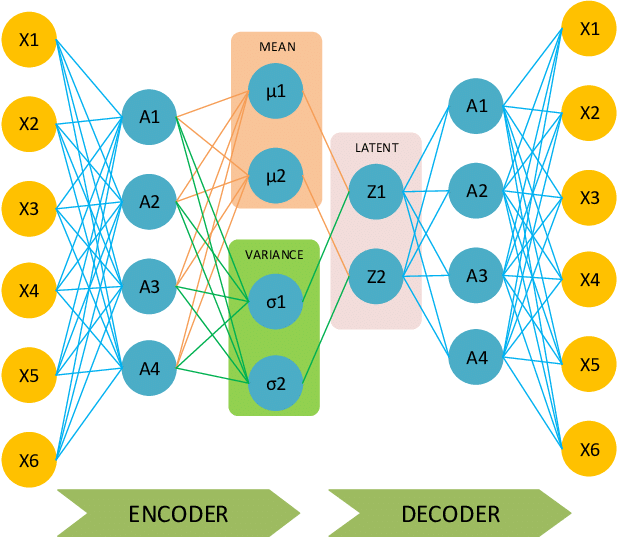  
[Source](https://jiki.cs.ui.ac.id/index.php/jiki/article/view/761)

### Output Dataclass

In [36]:
@dataclass
class VAEOutput:
    """
    Dataclass for Variational Autoencoder (VAE) output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """

    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

### Autoencoder Architecture

In [37]:
class VariationalAutoencoder(nn.Module):
    """
    Autoencoder (AE) class.

    Args:
        size_input (int): Dimensionality of the input data.
        size_hidden (int): Dimensionality of the hidden layer.
        size_latent (int): Dimensionality of the latent space
    """

    def __init__(self, size_input: int, size_hidden: int, size_latent: int):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(size_input, size_hidden),
            nn.SiLU(),  # Swish activation function
            nn.Linear(size_hidden, size_hidden // 2),
            nn.SiLU(),
            nn.Linear(size_hidden // 2, size_hidden // 4),
            nn.SiLU(),
            nn.Linear(size_hidden // 4, size_hidden // 8),
            nn.SiLU(),
            nn.Linear(size_hidden // 8, 2 * size_latent),  # For mean and variance
        )
        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential(
            nn.Linear(size_latent, size_hidden // 8),
            nn.SiLU(),
            nn.Linear(size_hidden // 8, size_hidden // 4),
            nn.SiLU(),
            nn.Linear(size_hidden // 4, size_hidden // 2),
            nn.SiLU(),
            nn.Linear(size_hidden // 2, size_hidden),
            nn.SiLU(),
            nn.Linear(size_hidden, size_input),
            nn.Sigmoid(),
        )

        # Set model to device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )

        # compute loss terms
        loss_recon = (
            F.binary_cross_entropy(recon_x, x + 0.5, reduction="none").sum(-1).mean()
        )
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device)
            .unsqueeze(0)
            .expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [39]:
model = VariationalAutoencoder(size_input, size_hidden, size_latent)
model

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

## Model Training

Training models with PyTorch involves the process of optimizing neural networks to learn patterns and make predictions from data. PyTorch, known for its dynamic computational graph and flexible architecture, facilitates efficient model training through features like automatic differentiation and GPU acceleration, enabling researchers and developers to implement and iterate on complex machine learning algorithms effectively.
> Generated with ChatGPT

Typical training loop:

- Iterating over mini-batches of data
- Forward Pass: Computing model predictions on input data
- Calculating Loss: Using the loss function to measure the discrepancy between predictions and ground truth
- Backward Pass: Computing gradients of the loss with respect to model parameters
- Optimizer Step: Updating model parameters using the optimizer

In [40]:
def train(model, dataloader, optimizer, prev_updates, device, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        optimizer (torch.optim.Optim): The optimizer.
        prev_updates (int): Number of previous updates.
        device (str): Device.
        writer: The TensorBoard writer.
    """
    model.train()  # Set the model to training mode

    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1.0 / 2)

            print(
                f"Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}"
            )

            if writer is not None:
                global_step = n_upd
                writer.add_scalar("Loss/Train", loss.item(), global_step)
                writer.add_scalar(
                    "Loss/Train/BCE", output.loss_recon.item(), global_step
                )
                writer.add_scalar("Loss/Train/KLD", output.loss_kl.item(), global_step)
                writer.add_scalar("GradNorm/Train", total_norm, global_step)

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [41]:
def test(model, dataloader, cur_step, latent_dim, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc="Testing"):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(
        f"====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})"
    )

    if writer is not None:
        writer.add_scalar("Loss/Test", test_loss, global_step=cur_step)
        writer.add_scalar(
            "Loss/Test/BCE", output.loss_recon.item(), global_step=cur_step
        )
        writer.add_scalar("Loss/Test/KLD", output.loss_kl.item(), global_step=cur_step)

        # Log reconstructions
        writer.add_images(
            "Test/Reconstructions",
            output.x_recon.view(-1, 1, 28, 28),
            global_step=cur_step,
        )
        writer.add_images(
            "Test/Originals", data.view(-1, 1, 28, 28), global_step=cur_step
        )

        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images(
            "Test/Samples", samples.view(-1, 1, 28, 28), global_step=cur_step
        )

In [42]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

prev_updates = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    prev_updates = train(
        model, train_loader, optimizer, prev_updates, device, writer=writer
    )
    test(model, test_loader, prev_updates, size_latent, writer=writer)

Epoch 1/50


  0%|          | 2/469 [00:00<00:29, 15.57it/s]

Step 0 (N samples: 0), Loss: 543.8928 (Recon: 543.6832, KL: 0.2095) Grad: 13.0905


 23%|██▎       | 106/469 [00:03<00:10, 34.71it/s]

Step 100 (N samples: 12,800), Loss: 205.6424 (Recon: 205.4945, KL: 0.1478) Grad: 26.4306


 44%|████▍     | 206/469 [00:06<00:08, 32.84it/s]

Step 200 (N samples: 25,600), Loss: 212.6903 (Recon: 212.5530, KL: 0.1374) Grad: 39.5371


 65%|██████▌   | 306/469 [00:09<00:05, 31.74it/s]

Step 300 (N samples: 38,400), Loss: 207.3431 (Recon: 207.2239, KL: 0.1192) Grad: 29.1476


 87%|████████▋ | 406/469 [00:12<00:01, 33.64it/s]

Step 400 (N samples: 51,200), Loss: 207.8585 (Recon: 207.7549, KL: 0.1036) Grad: 31.5077


Testing: 100%|██████████| 79/79 [00:01<00:00, 47.21it/s]


====> Test set loss: 206.9553 (BCE: 206.8634, KLD: 0.0919)
Epoch 2/50


  7%|▋         | 34/469 [00:02<00:33, 13.07it/s]

Step 500 (N samples: 64,000), Loss: 203.7049 (Recon: 203.6183, KL: 0.0866) Grad: 26.4945


 29%|██▉       | 135/469 [00:09<00:19, 17.57it/s]

Step 600 (N samples: 76,800), Loss: 213.7066 (Recon: 213.6353, KL: 0.0713) Grad: 36.5362


 50%|█████     | 235/469 [00:13<00:08, 28.20it/s]

Step 700 (N samples: 89,600), Loss: 208.4913 (Recon: 208.4309, KL: 0.0604) Grad: 26.9094


 71%|███████▏  | 335/469 [00:17<00:06, 21.06it/s]

Step 800 (N samples: 102,400), Loss: 204.4975 (Recon: 204.4475, KL: 0.0499) Grad: 29.1224


 93%|█████████▎| 435/469 [00:22<00:01, 22.25it/s]

Step 900 (N samples: 115,200), Loss: 210.3502 (Recon: 210.3090, KL: 0.0412) Grad: 34.4621


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.86it/s]


====> Test set loss: 206.5924 (BCE: 206.5543, KLD: 0.0381)
Epoch 3/50


 14%|█▍        | 66/469 [00:02<00:14, 27.59it/s]

Step 1,000 (N samples: 128,000), Loss: 203.3575 (Recon: 203.3227, KL: 0.0348) Grad: 27.6779


 36%|███▌      | 168/469 [00:06<00:10, 27.67it/s]

Step 1,100 (N samples: 140,800), Loss: 209.2319 (Recon: 209.2019, KL: 0.0300) Grad: 29.9103


 57%|█████▋    | 268/469 [00:09<00:07, 28.26it/s]

Step 1,200 (N samples: 153,600), Loss: 204.6167 (Recon: 204.5910, KL: 0.0256) Grad: 25.6600


 78%|███████▊  | 368/469 [00:13<00:03, 27.27it/s]

Step 1,300 (N samples: 166,400), Loss: 204.3644 (Recon: 204.3412, KL: 0.0232) Grad: 31.0092


 99%|█████████▉| 465/469 [00:17<00:00, 20.01it/s]

Step 1,400 (N samples: 179,200), Loss: 206.7537 (Recon: 206.7321, KL: 0.0216) Grad: 29.5205


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s]


====> Test set loss: 206.7214 (BCE: 206.7001, KLD: 0.0213)
Epoch 4/50


 21%|██        | 97/469 [00:05<00:22, 16.70it/s]

Step 1,500 (N samples: 192,000), Loss: 208.3081 (Recon: 208.2883, KL: 0.0198) Grad: 32.7727


 42%|████▏     | 195/469 [00:13<00:23, 11.59it/s]

Step 1,600 (N samples: 204,800), Loss: 202.0800 (Recon: 202.0609, KL: 0.0191) Grad: 29.0457


 63%|██████▎   | 295/469 [00:22<00:19,  8.87it/s]

Step 1,700 (N samples: 217,600), Loss: 208.0779 (Recon: 208.0594, KL: 0.0185) Grad: 28.1474


 84%|████████▍ | 395/469 [00:32<00:07,  9.89it/s]

Step 1,800 (N samples: 230,400), Loss: 203.3851 (Recon: 203.3669, KL: 0.0182) Grad: 29.8261


Testing: 100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


====> Test set loss: 206.7339 (BCE: 206.7163, KLD: 0.0175)
Epoch 5/50


  6%|▌         | 26/469 [00:03<00:51,  8.62it/s]

Step 1,900 (N samples: 243,200), Loss: 209.4773 (Recon: 209.4596, KL: 0.0177) Grad: 28.9717


 27%|██▋       | 126/469 [00:15<00:40,  8.39it/s]

Step 2,000 (N samples: 256,000), Loss: 216.3128 (Recon: 216.2955, KL: 0.0173) Grad: 36.7891


 48%|████▊     | 226/469 [00:28<00:37,  6.57it/s]

Step 2,100 (N samples: 268,800), Loss: 209.8852 (Recon: 209.8679, KL: 0.0173) Grad: 40.5781


 70%|██████▉   | 326/469 [00:42<00:22,  6.39it/s]

Step 2,200 (N samples: 281,600), Loss: 203.1270 (Recon: 203.1096, KL: 0.0174) Grad: 29.4458


 91%|█████████ | 426/469 [00:55<00:06,  7.05it/s]

Step 2,300 (N samples: 294,400), Loss: 206.7958 (Recon: 206.7787, KL: 0.0171) Grad: 24.2286


Testing: 100%|██████████| 79/79 [00:07<00:00, 10.84it/s]


====> Test set loss: 206.5369 (BCE: 206.5197, KLD: 0.0172)
Epoch 6/50


 12%|█▏        | 57/469 [00:08<00:57,  7.15it/s]

Step 2,400 (N samples: 307,200), Loss: 206.0850 (Recon: 206.0677, KL: 0.0173) Grad: 31.2065


 33%|███▎      | 157/469 [00:22<00:45,  6.91it/s]

Step 2,500 (N samples: 320,000), Loss: 210.5840 (Recon: 210.5666, KL: 0.0174) Grad: 29.6857


 55%|█████▍    | 257/469 [00:36<00:30,  7.04it/s]

Step 2,600 (N samples: 332,800), Loss: 211.2655 (Recon: 211.2482, KL: 0.0173) Grad: 31.4418


 76%|███████▌  | 357/469 [00:51<00:16,  6.89it/s]

Step 2,700 (N samples: 345,600), Loss: 214.0394 (Recon: 214.0217, KL: 0.0177) Grad: 29.8799


 97%|█████████▋| 457/469 [01:05<00:01,  6.94it/s]

Step 2,800 (N samples: 358,400), Loss: 204.8963 (Recon: 204.8786, KL: 0.0177) Grad: 28.0459


Testing: 100%|██████████| 79/79 [00:07<00:00, 10.96it/s]


====> Test set loss: 206.4620 (BCE: 206.4444, KLD: 0.0176)
Epoch 7/50


 19%|█▉        | 88/469 [00:13<00:56,  6.72it/s]

Step 2,900 (N samples: 371,200), Loss: 210.5264 (Recon: 210.5088, KL: 0.0177) Grad: 34.0731


 40%|████      | 188/469 [00:28<00:42,  6.59it/s]

Step 3,000 (N samples: 384,000), Loss: 202.3405 (Recon: 202.3223, KL: 0.0182) Grad: 23.9274


 61%|██████▏   | 288/469 [00:43<00:27,  6.62it/s]

Step 3,100 (N samples: 396,800), Loss: 205.5794 (Recon: 205.5610, KL: 0.0184) Grad: 27.1870


 83%|████████▎ | 388/469 [00:59<00:13,  5.98it/s]

Step 3,200 (N samples: 409,600), Loss: 205.3841 (Recon: 205.3666, KL: 0.0175) Grad: 25.1427


Testing: 100%|██████████| 79/79 [00:07<00:00, 10.49it/s]


====> Test set loss: 206.4793 (BCE: 206.4618, KLD: 0.0175)
Epoch 8/50


  4%|▍         | 19/469 [00:03<01:13,  6.12it/s]

Step 3,300 (N samples: 422,400), Loss: 203.6016 (Recon: 203.5839, KL: 0.0177) Grad: 29.5805


 25%|██▌       | 118/469 [00:19<00:55,  6.38it/s]

Step 3,400 (N samples: 435,200), Loss: 207.3019 (Recon: 207.2839, KL: 0.0180) Grad: 30.0248


 47%|████▋     | 219/469 [00:35<00:41,  5.98it/s]

Step 3,500 (N samples: 448,000), Loss: 210.7038 (Recon: 210.6855, KL: 0.0183) Grad: 26.5705


 68%|██████▊   | 319/469 [00:52<00:26,  5.64it/s]

Step 3,600 (N samples: 460,800), Loss: 212.7276 (Recon: 212.7094, KL: 0.0183) Grad: 24.9115


 89%|████████▉ | 418/469 [01:13<00:10,  4.81it/s]

Step 3,700 (N samples: 473,600), Loss: 203.9965 (Recon: 203.9786, KL: 0.0179) Grad: 29.0518


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


====> Test set loss: 206.3643 (BCE: 206.3461, KLD: 0.0182)
Epoch 9/50


 10%|█         | 49/469 [00:13<01:54,  3.68it/s]

Step 3,800 (N samples: 486,400), Loss: 205.8978 (Recon: 205.8795, KL: 0.0182) Grad: 36.9303


 32%|███▏      | 148/469 [00:41<02:28,  2.16it/s]

Step 3,900 (N samples: 499,200), Loss: 209.0064 (Recon: 208.9883, KL: 0.0182) Grad: 31.3233


 53%|█████▎    | 249/469 [01:24<01:52,  1.96it/s]

Step 4,000 (N samples: 512,000), Loss: 206.8130 (Recon: 206.7948, KL: 0.0181) Grad: 31.9599


 74%|███████▍  | 349/469 [02:00<00:37,  3.22it/s]

Step 4,100 (N samples: 524,800), Loss: 202.5812 (Recon: 202.5632, KL: 0.0180) Grad: 26.5115


 96%|█████████▌| 449/469 [02:37<00:05,  3.80it/s]

Step 4,200 (N samples: 537,600), Loss: 203.7592 (Recon: 203.7413, KL: 0.0179) Grad: 30.0252


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.38it/s]


====> Test set loss: 206.5618 (BCE: 206.5439, KLD: 0.0180)
Epoch 10/50


 17%|█▋        | 80/469 [00:22<01:50,  3.52it/s]

Step 4,300 (N samples: 550,400), Loss: 207.6062 (Recon: 207.5880, KL: 0.0183) Grad: 30.1740


 38%|███▊      | 180/469 [00:53<01:23,  3.45it/s]

Step 4,400 (N samples: 563,200), Loss: 207.4047 (Recon: 207.3863, KL: 0.0183) Grad: 28.1122


 60%|█████▉    | 280/469 [01:20<00:44,  4.27it/s]

Step 4,500 (N samples: 576,000), Loss: 212.2191 (Recon: 212.2008, KL: 0.0182) Grad: 28.6504


 81%|████████  | 380/469 [01:43<00:20,  4.31it/s]

Step 4,600 (N samples: 588,800), Loss: 205.2989 (Recon: 205.2803, KL: 0.0187) Grad: 28.8264


Testing: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s]


====> Test set loss: 206.2263 (BCE: 206.2079, KLD: 0.0184)
Epoch 11/50


  2%|▏         | 11/469 [00:02<01:46,  4.31it/s]

Step 4,700 (N samples: 601,600), Loss: 212.7418 (Recon: 212.7234, KL: 0.0184) Grad: 31.3890


 24%|██▎       | 111/469 [00:34<01:54,  3.13it/s]

Step 4,800 (N samples: 614,400), Loss: 203.0366 (Recon: 203.0187, KL: 0.0179) Grad: 36.1643


 45%|████▍     | 211/469 [01:00<00:56,  4.53it/s]

Step 4,900 (N samples: 627,200), Loss: 210.7780 (Recon: 210.7599, KL: 0.0181) Grad: 31.9724


 66%|██████▋   | 311/469 [01:19<00:28,  5.55it/s]

Step 5,000 (N samples: 640,000), Loss: 201.9209 (Recon: 201.9025, KL: 0.0184) Grad: 24.9868


 88%|████████▊ | 411/469 [01:39<00:10,  5.58it/s]

Step 5,100 (N samples: 652,800), Loss: 204.1772 (Recon: 204.1587, KL: 0.0185) Grad: 31.6779


Testing: 100%|██████████| 79/79 [00:06<00:00, 12.68it/s]


====> Test set loss: 206.4281 (BCE: 206.4102, KLD: 0.0178)
Epoch 12/50


  9%|▉         | 42/469 [00:08<01:20,  5.30it/s]

Step 5,200 (N samples: 665,600), Loss: 199.5522 (Recon: 199.5325, KL: 0.0197) Grad: 37.2581


 30%|███       | 143/469 [00:27<01:02,  5.25it/s]

Step 5,300 (N samples: 678,400), Loss: 208.8636 (Recon: 208.8455, KL: 0.0181) Grad: 24.6215


 52%|█████▏    | 243/469 [00:46<00:38,  5.83it/s]

Step 5,400 (N samples: 691,200), Loss: 215.2842 (Recon: 215.2661, KL: 0.0181) Grad: 32.1028


 73%|███████▎  | 342/469 [01:06<00:26,  4.75it/s]

Step 5,500 (N samples: 704,000), Loss: 210.4953 (Recon: 210.4767, KL: 0.0186) Grad: 28.4385


 94%|█████████▍| 443/469 [01:27<00:05,  4.83it/s]

Step 5,600 (N samples: 716,800), Loss: 214.2026 (Recon: 214.1847, KL: 0.0178) Grad: 34.9492


Testing: 100%|██████████| 79/79 [00:06<00:00, 11.95it/s]


====> Test set loss: 206.2387 (BCE: 206.2205, KLD: 0.0182)
Epoch 13/50


 16%|█▌        | 74/469 [00:15<01:08,  5.80it/s]

Step 5,700 (N samples: 729,600), Loss: 205.4784 (Recon: 205.4599, KL: 0.0185) Grad: 33.4614


 37%|███▋      | 173/469 [00:37<01:10,  4.20it/s]

Step 5,800 (N samples: 742,400), Loss: 201.7550 (Recon: 201.7364, KL: 0.0186) Grad: 36.2689


 58%|█████▊    | 273/469 [01:01<00:50,  3.87it/s]

Step 5,900 (N samples: 755,200), Loss: 207.9773 (Recon: 207.9589, KL: 0.0184) Grad: 26.6366


 80%|███████▉  | 374/469 [01:20<00:18,  5.06it/s]

Step 6,000 (N samples: 768,000), Loss: 199.5191 (Recon: 199.5006, KL: 0.0185) Grad: 34.2428


Testing: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s]


====> Test set loss: 206.2883 (BCE: 206.2697, KLD: 0.0186)
Epoch 14/50


  1%|          | 4/469 [00:00<01:32,  5.05it/s]

Step 6,100 (N samples: 780,800), Loss: 212.6512 (Recon: 212.6326, KL: 0.0186) Grad: 31.3328


 22%|██▏       | 104/469 [00:19<01:05,  5.56it/s]

Step 6,200 (N samples: 793,600), Loss: 203.9713 (Recon: 203.9517, KL: 0.0196) Grad: 33.6644


 43%|████▎     | 204/469 [00:36<00:47,  5.58it/s]

Step 6,300 (N samples: 806,400), Loss: 201.0150 (Recon: 200.9978, KL: 0.0172) Grad: 33.8346


 65%|██████▍   | 304/469 [00:55<00:28,  5.76it/s]

Step 6,400 (N samples: 819,200), Loss: 215.5890 (Recon: 215.5709, KL: 0.0181) Grad: 34.9929


 86%|████████▋ | 405/469 [01:11<00:09,  7.00it/s]

Step 6,500 (N samples: 832,000), Loss: 209.2229 (Recon: 209.2045, KL: 0.0184) Grad: 26.1523


Testing: 100%|██████████| 79/79 [00:05<00:00, 14.83it/s]


====> Test set loss: 206.1045 (BCE: 206.0858, KLD: 0.0188)
Epoch 15/50


  8%|▊         | 36/469 [00:05<01:11,  6.10it/s]

Step 6,600 (N samples: 844,800), Loss: 222.0853 (Recon: 222.0664, KL: 0.0190) Grad: 45.8672


 29%|██▉       | 136/469 [00:19<00:44,  7.49it/s]

Step 6,700 (N samples: 857,600), Loss: 208.2233 (Recon: 208.2047, KL: 0.0186) Grad: 31.0256


 50%|█████     | 236/469 [00:32<00:29,  7.78it/s]

Step 6,800 (N samples: 870,400), Loss: 204.5374 (Recon: 204.5195, KL: 0.0179) Grad: 34.0841


 72%|███████▏  | 336/469 [00:46<00:16,  7.90it/s]

Step 6,900 (N samples: 883,200), Loss: 207.8862 (Recon: 207.8667, KL: 0.0195) Grad: 37.1671


 93%|█████████▎| 436/469 [00:59<00:04,  7.41it/s]

Step 7,000 (N samples: 896,000), Loss: 199.6372 (Recon: 199.6190, KL: 0.0181) Grad: 38.5284


Testing: 100%|██████████| 79/79 [00:05<00:00, 14.93it/s]


====> Test set loss: 206.2172 (BCE: 206.1990, KLD: 0.0182)
Epoch 16/50


 14%|█▍        | 67/469 [00:09<00:50,  7.96it/s]

Step 7,100 (N samples: 908,800), Loss: 203.0557 (Recon: 203.0370, KL: 0.0187) Grad: 30.6531


 36%|███▌      | 167/469 [00:23<00:37,  8.07it/s]

Step 7,200 (N samples: 921,600), Loss: 206.7874 (Recon: 206.7691, KL: 0.0183) Grad: 27.4144


 57%|█████▋    | 267/469 [00:36<00:27,  7.28it/s]

Step 7,300 (N samples: 934,400), Loss: 208.6469 (Recon: 208.6279, KL: 0.0191) Grad: 32.3836


 78%|███████▊  | 367/469 [00:49<00:12,  8.01it/s]

Step 7,400 (N samples: 947,200), Loss: 213.1025 (Recon: 213.0833, KL: 0.0192) Grad: 35.6072


100%|█████████▉| 467/469 [01:02<00:00,  7.48it/s]

Step 7,500 (N samples: 960,000), Loss: 203.7478 (Recon: 203.7285, KL: 0.0193) Grad: 32.2019


Testing: 100%|██████████| 79/79 [00:04<00:00, 16.67it/s]


====> Test set loss: 206.3980 (BCE: 206.3784, KLD: 0.0195)
Epoch 17/50


 21%|██        | 98/469 [00:12<00:48,  7.68it/s]

Step 7,600 (N samples: 972,800), Loss: 211.3163 (Recon: 211.2976, KL: 0.0187) Grad: 31.0209


 42%|████▏     | 198/469 [00:24<00:33,  8.17it/s]

Step 7,700 (N samples: 985,600), Loss: 201.7073 (Recon: 201.6883, KL: 0.0189) Grad: 39.7118


 64%|██████▎   | 298/469 [00:37<00:24,  7.03it/s]

Step 7,800 (N samples: 998,400), Loss: 206.0033 (Recon: 205.9850, KL: 0.0183) Grad: 28.9344


 85%|████████▍ | 398/469 [00:50<00:08,  8.43it/s]

Step 7,900 (N samples: 1,011,200), Loss: 196.5578 (Recon: 196.5403, KL: 0.0176) Grad: 43.5109


Testing: 100%|██████████| 79/79 [00:04<00:00, 17.35it/s]


====> Test set loss: 206.3126 (BCE: 206.2929, KLD: 0.0197)
Epoch 18/50


  6%|▌         | 28/469 [00:03<00:54,  8.13it/s]

Step 8,000 (N samples: 1,024,000), Loss: 207.2327 (Recon: 207.2138, KL: 0.0190) Grad: 29.4726


 28%|██▊       | 129/469 [00:20<00:41,  8.23it/s]

Step 8,100 (N samples: 1,036,800), Loss: 204.8567 (Recon: 204.8393, KL: 0.0174) Grad: 26.6690


 49%|████▉     | 229/469 [00:32<00:33,  7.25it/s]

Step 8,200 (N samples: 1,049,600), Loss: 209.1959 (Recon: 209.1771, KL: 0.0188) Grad: 24.9209


 70%|███████   | 329/469 [00:44<00:19,  7.15it/s]

Step 8,300 (N samples: 1,062,400), Loss: 205.8613 (Recon: 205.8425, KL: 0.0188) Grad: 32.9369


 91%|█████████▏| 428/469 [10:40<00:03, 11.40it/s]   

Step 8,400 (N samples: 1,075,200), Loss: 213.9332 (Recon: 213.9156, KL: 0.0176) Grad: 32.9019


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.74it/s]


====> Test set loss: 206.3868 (BCE: 206.3682, KLD: 0.0186)
Epoch 19/50


 13%|█▎        | 60/469 [00:04<00:29, 13.71it/s]

Step 8,500 (N samples: 1,088,000), Loss: 203.4437 (Recon: 203.4234, KL: 0.0203) Grad: 28.1119


 34%|███▍      | 160/469 [00:11<00:23, 13.17it/s]

Step 8,600 (N samples: 1,100,800), Loss: 207.3161 (Recon: 207.2973, KL: 0.0187) Grad: 32.3561


 55%|█████▌    | 260/469 [00:19<00:16, 12.37it/s]

Step 8,700 (N samples: 1,113,600), Loss: 209.5368 (Recon: 209.5188, KL: 0.0180) Grad: 31.8693


 77%|███████▋  | 360/469 [00:28<00:09, 11.04it/s]

Step 8,800 (N samples: 1,126,400), Loss: 211.1281 (Recon: 211.1098, KL: 0.0184) Grad: 32.8353


 98%|█████████▊| 461/469 [00:36<00:00, 13.58it/s]

Step 8,900 (N samples: 1,139,200), Loss: 209.8360 (Recon: 209.8175, KL: 0.0185) Grad: 33.2062


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.14it/s]


====> Test set loss: 206.2551 (BCE: 206.2362, KLD: 0.0189)
Epoch 20/50


 20%|█▉        | 92/469 [00:06<00:27, 13.82it/s]

Step 9,000 (N samples: 1,152,000), Loss: 201.3343 (Recon: 201.3167, KL: 0.0177) Grad: 34.4639


 41%|████      | 192/469 [00:13<00:20, 13.30it/s]

Step 9,100 (N samples: 1,164,800), Loss: 202.8355 (Recon: 202.8171, KL: 0.0184) Grad: 29.6405


 62%|██████▏   | 292/469 [00:21<00:12, 13.84it/s]

Step 9,200 (N samples: 1,177,600), Loss: 202.7384 (Recon: 202.7196, KL: 0.0188) Grad: 34.5749


 84%|████████▎ | 392/469 [00:28<00:05, 14.20it/s]

Step 9,300 (N samples: 1,190,400), Loss: 206.9028 (Recon: 206.8840, KL: 0.0188) Grad: 34.5987


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.61it/s]


====> Test set loss: 206.2577 (BCE: 206.2382, KLD: 0.0195)
Epoch 21/50


  5%|▍         | 22/469 [00:01<00:32, 13.90it/s]

Step 9,400 (N samples: 1,203,200), Loss: 206.5724 (Recon: 206.5533, KL: 0.0191) Grad: 31.4089


 26%|██▌       | 122/469 [00:08<00:25, 13.84it/s]

Step 9,500 (N samples: 1,216,000), Loss: 209.7084 (Recon: 209.6899, KL: 0.0185) Grad: 29.1952


 47%|████▋     | 222/469 [00:16<00:17, 13.77it/s]

Step 9,600 (N samples: 1,228,800), Loss: 208.4366 (Recon: 208.4177, KL: 0.0189) Grad: 28.9136


 69%|██████▊   | 322/469 [00:23<00:10, 13.52it/s]

Step 9,700 (N samples: 1,241,600), Loss: 203.3964 (Recon: 203.3781, KL: 0.0183) Grad: 33.9807


 90%|████████▉ | 422/469 [00:30<00:03, 14.03it/s]

Step 9,800 (N samples: 1,254,400), Loss: 209.3727 (Recon: 209.3529, KL: 0.0198) Grad: 29.8158


Testing: 100%|██████████| 79/79 [00:02<00:00, 33.41it/s]


====> Test set loss: 206.4181 (BCE: 206.3991, KLD: 0.0191)
Epoch 22/50


 12%|█▏        | 54/469 [00:04<00:31, 13.01it/s]

Step 9,900 (N samples: 1,267,200), Loss: 206.8290 (Recon: 206.8102, KL: 0.0187) Grad: 35.6232


 32%|███▏      | 152/469 [00:11<00:23, 13.65it/s]

Step 10,000 (N samples: 1,280,000), Loss: 205.6137 (Recon: 205.5962, KL: 0.0176) Grad: 33.8008


 54%|█████▍    | 254/469 [00:19<00:16, 13.03it/s]

Step 10,100 (N samples: 1,292,800), Loss: 201.6289 (Recon: 201.6104, KL: 0.0185) Grad: 33.2052


 75%|███████▌  | 354/469 [00:26<00:08, 13.37it/s]

Step 10,200 (N samples: 1,305,600), Loss: 205.4520 (Recon: 205.4329, KL: 0.0191) Grad: 30.6301


 97%|█████████▋| 454/469 [00:34<00:01, 13.06it/s]

Step 10,300 (N samples: 1,318,400), Loss: 199.3132 (Recon: 199.2948, KL: 0.0183) Grad: 32.3106


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s]


====> Test set loss: 206.2951 (BCE: 206.2766, KLD: 0.0184)
Epoch 23/50


 18%|█▊        | 84/469 [00:06<00:30, 12.67it/s]

Step 10,400 (N samples: 1,331,200), Loss: 201.5035 (Recon: 201.4840, KL: 0.0195) Grad: 29.0540


 39%|███▉      | 184/469 [00:14<00:23, 11.88it/s]

Step 10,500 (N samples: 1,344,000), Loss: 209.9569 (Recon: 209.9388, KL: 0.0181) Grad: 29.3167


 61%|██████    | 284/469 [00:23<00:16, 11.12it/s]

Step 10,600 (N samples: 1,356,800), Loss: 202.8642 (Recon: 202.8452, KL: 0.0190) Grad: 29.9975


 82%|████████▏ | 384/469 [00:31<00:07, 11.63it/s]

Step 10,700 (N samples: 1,369,600), Loss: 206.1692 (Recon: 206.1500, KL: 0.0191) Grad: 27.6240


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.16it/s]


====> Test set loss: 206.3273 (BCE: 206.3081, KLD: 0.0192)
Epoch 24/50


  3%|▎         | 15/469 [00:01<00:44, 10.19it/s]

Step 10,800 (N samples: 1,382,400), Loss: 208.1004 (Recon: 208.0824, KL: 0.0181) Grad: 29.7545


 25%|██▍       | 115/469 [00:10<00:30, 11.68it/s]

Step 10,900 (N samples: 1,395,200), Loss: 204.3810 (Recon: 204.3624, KL: 0.0186) Grad: 32.1935


 46%|████▌     | 215/469 [00:18<00:22, 11.32it/s]

Step 11,000 (N samples: 1,408,000), Loss: 213.3065 (Recon: 213.2870, KL: 0.0195) Grad: 30.0600


 67%|██████▋   | 315/469 [00:27<00:13, 11.72it/s]

Step 11,100 (N samples: 1,420,800), Loss: 202.4569 (Recon: 202.4389, KL: 0.0180) Grad: 25.9083


 88%|████████▊ | 415/469 [00:36<00:04, 11.80it/s]

Step 11,200 (N samples: 1,433,600), Loss: 219.1089 (Recon: 219.0900, KL: 0.0190) Grad: 47.0024


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.34it/s]


====> Test set loss: 206.2962 (BCE: 206.2770, KLD: 0.0192)
Epoch 25/50


 10%|▉         | 46/469 [00:03<00:35, 12.05it/s]

Step 11,300 (N samples: 1,446,400), Loss: 202.9490 (Recon: 202.9301, KL: 0.0190) Grad: 32.2805


 31%|███       | 146/469 [00:12<00:27, 11.71it/s]

Step 11,400 (N samples: 1,459,200), Loss: 204.3989 (Recon: 204.3808, KL: 0.0181) Grad: 31.3361


 52%|█████▏    | 246/469 [00:21<00:18, 11.82it/s]

Step 11,500 (N samples: 1,472,000), Loss: 206.9918 (Recon: 206.9735, KL: 0.0183) Grad: 30.0530


 74%|███████▍  | 347/469 [00:31<00:10, 12.00it/s]

Step 11,600 (N samples: 1,484,800), Loss: 205.7858 (Recon: 205.7670, KL: 0.0188) Grad: 27.8878


 95%|█████████▌| 447/469 [00:39<00:01, 12.23it/s]

Step 11,700 (N samples: 1,497,600), Loss: 209.1734 (Recon: 209.1546, KL: 0.0188) Grad: 36.9098


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.73it/s]


====> Test set loss: 206.2248 (BCE: 206.2052, KLD: 0.0197)
Epoch 26/50


 17%|█▋        | 78/469 [00:06<00:33, 11.51it/s]

Step 11,800 (N samples: 1,510,400), Loss: 206.0940 (Recon: 206.0761, KL: 0.0179) Grad: 28.4337


 38%|███▊      | 178/469 [00:15<00:24, 11.74it/s]

Step 11,900 (N samples: 1,523,200), Loss: 205.5359 (Recon: 205.5160, KL: 0.0199) Grad: 26.0135


 59%|█████▉    | 278/469 [00:23<00:15, 11.94it/s]

Step 12,000 (N samples: 1,536,000), Loss: 202.2576 (Recon: 202.2378, KL: 0.0197) Grad: 31.2273


 81%|████████  | 378/469 [00:31<00:07, 11.79it/s]

Step 12,100 (N samples: 1,548,800), Loss: 208.6013 (Recon: 208.5824, KL: 0.0188) Grad: 29.8250


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.88it/s]


====> Test set loss: 206.1948 (BCE: 206.1759, KLD: 0.0189)
Epoch 27/50


  2%|▏         | 8/469 [00:00<00:35, 12.90it/s]

Step 12,200 (N samples: 1,561,600), Loss: 206.7995 (Recon: 206.7802, KL: 0.0193) Grad: 30.9836


 23%|██▎       | 108/469 [00:08<00:29, 12.36it/s]

Step 12,300 (N samples: 1,574,400), Loss: 206.0931 (Recon: 206.0755, KL: 0.0177) Grad: 38.4663


 44%|████▍     | 208/469 [00:18<00:21, 12.06it/s]

Step 12,400 (N samples: 1,587,200), Loss: 207.1494 (Recon: 207.1308, KL: 0.0186) Grad: 29.1722


 66%|██████▌   | 308/469 [00:26<00:12, 12.99it/s]

Step 12,500 (N samples: 1,600,000), Loss: 207.2233 (Recon: 207.2033, KL: 0.0199) Grad: 35.9355


 87%|████████▋ | 408/469 [00:34<00:04, 13.06it/s]

Step 12,600 (N samples: 1,612,800), Loss: 204.7335 (Recon: 204.7154, KL: 0.0180) Grad: 27.2264


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.77it/s]


====> Test set loss: 206.2861 (BCE: 206.2667, KLD: 0.0194)
Epoch 28/50


  9%|▊         | 40/469 [00:03<00:33, 12.92it/s]

Step 12,700 (N samples: 1,625,600), Loss: 207.9534 (Recon: 207.9338, KL: 0.0196) Grad: 25.2438


 30%|██▉       | 140/469 [00:10<00:24, 13.17it/s]

Step 12,800 (N samples: 1,638,400), Loss: 213.1656 (Recon: 213.1469, KL: 0.0187) Grad: 27.3641


 51%|█████     | 240/469 [00:18<00:16, 14.27it/s]

Step 12,900 (N samples: 1,651,200), Loss: 204.3403 (Recon: 204.3209, KL: 0.0195) Grad: 38.0469


 72%|███████▏  | 340/469 [00:25<00:08, 15.51it/s]

Step 13,000 (N samples: 1,664,000), Loss: 207.9909 (Recon: 207.9718, KL: 0.0191) Grad: 28.4968


 94%|█████████▍| 440/469 [00:31<00:01, 15.54it/s]

Step 13,100 (N samples: 1,676,800), Loss: 206.2950 (Recon: 206.2766, KL: 0.0183) Grad: 34.6733


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.68it/s]


====> Test set loss: 206.2554 (BCE: 206.2360, KLD: 0.0194)
Epoch 29/50


 15%|█▌        | 72/469 [00:04<00:24, 15.92it/s]

Step 13,200 (N samples: 1,689,600), Loss: 209.6332 (Recon: 209.6153, KL: 0.0179) Grad: 29.6409


 37%|███▋      | 172/469 [00:11<00:18, 15.95it/s]

Step 13,300 (N samples: 1,702,400), Loss: 207.1798 (Recon: 207.1610, KL: 0.0187) Grad: 28.2708


 58%|█████▊    | 272/469 [00:17<00:11, 16.61it/s]

Step 13,400 (N samples: 1,715,200), Loss: 210.3784 (Recon: 210.3602, KL: 0.0182) Grad: 31.3733


 79%|███████▉  | 372/469 [00:23<00:05, 16.73it/s]

Step 13,500 (N samples: 1,728,000), Loss: 207.6621 (Recon: 207.6438, KL: 0.0183) Grad: 35.0754


100%|██████████| 469/469 [00:29<00:00, 15.92it/s]


Step 13,600 (N samples: 1,740,800), Loss: 202.2662 (Recon: 202.2484, KL: 0.0179) Grad: 35.3815


Testing: 100%|██████████| 79/79 [00:02<00:00, 33.46it/s]


====> Test set loss: 206.2249 (BCE: 206.2070, KLD: 0.0179)
Epoch 30/50


 22%|██▏       | 103/469 [00:05<00:20, 17.76it/s]

Step 13,700 (N samples: 1,753,600), Loss: 200.9343 (Recon: 200.9158, KL: 0.0185) Grad: 27.9328


 43%|████▎     | 204/469 [00:10<00:12, 21.12it/s]

Step 13,800 (N samples: 1,766,400), Loss: 203.2392 (Recon: 203.2211, KL: 0.0181) Grad: 28.5829


 64%|██████▍   | 301/469 [00:15<00:07, 21.09it/s]

Step 13,900 (N samples: 1,779,200), Loss: 209.2121 (Recon: 209.1922, KL: 0.0199) Grad: 32.2564


 86%|████████▌ | 402/469 [00:20<00:03, 19.67it/s]

Step 14,000 (N samples: 1,792,000), Loss: 208.8466 (Recon: 208.8277, KL: 0.0190) Grad: 35.7606


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.73it/s]


====> Test set loss: 206.2491 (BCE: 206.2299, KLD: 0.0192)
Epoch 31/50


  7%|▋         | 34/469 [00:01<00:21, 20.33it/s]

Step 14,100 (N samples: 1,804,800), Loss: 210.6464 (Recon: 210.6274, KL: 0.0190) Grad: 27.7590


 29%|██▉       | 135/469 [00:06<00:15, 21.00it/s]

Step 14,200 (N samples: 1,817,600), Loss: 203.3519 (Recon: 203.3327, KL: 0.0191) Grad: 25.0584


 50%|█████     | 235/469 [00:11<00:10, 21.33it/s]

Step 14,300 (N samples: 1,830,400), Loss: 209.8142 (Recon: 209.7956, KL: 0.0186) Grad: 31.8506


 71%|███████   | 334/469 [00:16<00:07, 18.58it/s]

Step 14,400 (N samples: 1,843,200), Loss: 200.9371 (Recon: 200.9178, KL: 0.0193) Grad: 32.2638


 92%|█████████▏| 431/469 [00:21<00:01, 20.69it/s]

Step 14,500 (N samples: 1,856,000), Loss: 205.7726 (Recon: 205.7540, KL: 0.0186) Grad: 29.8378


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.17it/s]


====> Test set loss: 206.3274 (BCE: 206.3090, KLD: 0.0185)
Epoch 32/50


 14%|█▎        | 64/469 [00:03<00:23, 16.93it/s]

Step 14,600 (N samples: 1,868,800), Loss: 205.2931 (Recon: 205.2734, KL: 0.0197) Grad: 33.2971


 35%|███▍      | 163/469 [00:09<00:18, 16.55it/s]

Step 14,700 (N samples: 1,881,600), Loss: 209.0364 (Recon: 209.0176, KL: 0.0188) Grad: 30.6333


 57%|█████▋    | 265/469 [00:14<00:09, 20.53it/s]

Step 14,800 (N samples: 1,894,400), Loss: 204.0299 (Recon: 204.0112, KL: 0.0187) Grad: 30.5760


 78%|███████▊  | 365/469 [00:19<00:05, 20.63it/s]

Step 14,900 (N samples: 1,907,200), Loss: 201.2203 (Recon: 201.2001, KL: 0.0202) Grad: 36.0108


 99%|█████████▉| 465/469 [00:24<00:00, 20.29it/s]

Step 15,000 (N samples: 1,920,000), Loss: 216.6444 (Recon: 216.6253, KL: 0.0191) Grad: 38.0167


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.22it/s]


====> Test set loss: 206.3302 (BCE: 206.3104, KLD: 0.0199)
Epoch 33/50


 20%|██        | 96/469 [00:04<00:18, 20.47it/s]

Step 15,100 (N samples: 1,932,800), Loss: 202.5483 (Recon: 202.5298, KL: 0.0185) Grad: 30.0189


 42%|████▏     | 196/469 [00:09<00:13, 19.81it/s]

Step 15,200 (N samples: 1,945,600), Loss: 211.9011 (Recon: 211.8836, KL: 0.0175) Grad: 37.3390


 63%|██████▎   | 295/469 [00:14<00:08, 19.87it/s]

Step 15,300 (N samples: 1,958,400), Loss: 210.1778 (Recon: 210.1590, KL: 0.0189) Grad: 34.8002


 85%|████████▍ | 397/469 [00:19<00:03, 21.20it/s]

Step 15,400 (N samples: 1,971,200), Loss: 205.8212 (Recon: 205.8028, KL: 0.0183) Grad: 27.2958


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.37it/s]


====> Test set loss: 206.3581 (BCE: 206.3390, KLD: 0.0191)
Epoch 34/50


  6%|▌         | 27/469 [00:01<00:22, 19.41it/s]

Step 15,500 (N samples: 1,984,000), Loss: 206.0036 (Recon: 205.9848, KL: 0.0188) Grad: 26.8680


 27%|██▋       | 125/469 [00:06<00:20, 16.57it/s]

Step 15,600 (N samples: 1,996,800), Loss: 205.9786 (Recon: 205.9604, KL: 0.0182) Grad: 36.3649


 49%|████▊     | 228/469 [00:11<00:11, 20.54it/s]

Step 15,700 (N samples: 2,009,600), Loss: 203.7919 (Recon: 203.7739, KL: 0.0180) Grad: 32.8102


 70%|██████▉   | 327/469 [00:16<00:06, 20.44it/s]

Step 15,800 (N samples: 2,022,400), Loss: 211.9989 (Recon: 211.9799, KL: 0.0191) Grad: 36.1909


 91%|█████████ | 427/469 [00:21<00:02, 20.51it/s]

Step 15,900 (N samples: 2,035,200), Loss: 208.4116 (Recon: 208.3935, KL: 0.0181) Grad: 23.8843


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.69it/s]


====> Test set loss: 206.3458 (BCE: 206.3261, KLD: 0.0197)
Epoch 35/50


 12%|█▏        | 57/469 [00:02<00:20, 20.30it/s]

Step 16,000 (N samples: 2,048,000), Loss: 213.0037 (Recon: 212.9842, KL: 0.0195) Grad: 30.4698


 34%|███▎      | 158/469 [00:07<00:15, 19.68it/s]

Step 16,100 (N samples: 2,060,800), Loss: 198.8715 (Recon: 198.8535, KL: 0.0180) Grad: 26.9254


 55%|█████▍    | 257/469 [00:12<00:10, 20.32it/s]

Step 16,200 (N samples: 2,073,600), Loss: 203.3353 (Recon: 203.3176, KL: 0.0178) Grad: 30.2998


 77%|███████▋  | 359/469 [00:17<00:05, 20.15it/s]

Step 16,300 (N samples: 2,086,400), Loss: 206.0695 (Recon: 206.0498, KL: 0.0197) Grad: 30.2460


 97%|█████████▋| 457/469 [00:22<00:00, 19.58it/s]

Step 16,400 (N samples: 2,099,200), Loss: 209.7134 (Recon: 209.6951, KL: 0.0183) Grad: 35.9487


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.24it/s]


====> Test set loss: 206.2810 (BCE: 206.2629, KLD: 0.0181)
Epoch 36/50


 19%|█▉        | 89/469 [00:04<00:18, 20.23it/s]

Step 16,500 (N samples: 2,112,000), Loss: 201.1052 (Recon: 201.0864, KL: 0.0188) Grad: 32.0713


 40%|████      | 189/469 [00:09<00:13, 20.49it/s]

Step 16,600 (N samples: 2,124,800), Loss: 212.9391 (Recon: 212.9199, KL: 0.0192) Grad: 33.2166


 61%|██████▏   | 288/469 [00:14<00:08, 21.49it/s]

Step 16,700 (N samples: 2,137,600), Loss: 201.6928 (Recon: 201.6745, KL: 0.0183) Grad: 30.7492


 83%|████████▎ | 390/469 [00:19<00:03, 21.80it/s]

Step 16,800 (N samples: 2,150,400), Loss: 201.5771 (Recon: 201.5576, KL: 0.0194) Grad: 31.5253


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.38it/s]


====> Test set loss: 206.2937 (BCE: 206.2753, KLD: 0.0184)
Epoch 37/50


  4%|▍         | 20/469 [00:00<00:20, 21.52it/s]

Step 16,900 (N samples: 2,163,200), Loss: 206.7576 (Recon: 206.7395, KL: 0.0181) Grad: 27.9617


 26%|██▌       | 120/469 [00:05<00:16, 21.41it/s]

Step 17,000 (N samples: 2,176,000), Loss: 208.4181 (Recon: 208.3994, KL: 0.0187) Grad: 32.2122


 47%|████▋     | 219/469 [00:10<00:12, 20.24it/s]

Step 17,100 (N samples: 2,188,800), Loss: 207.5348 (Recon: 207.5168, KL: 0.0180) Grad: 29.5715


 68%|██████▊   | 321/469 [00:15<00:06, 21.37it/s]

Step 17,200 (N samples: 2,201,600), Loss: 208.2116 (Recon: 208.1928, KL: 0.0188) Grad: 33.5993


 89%|████████▉ | 419/469 [00:20<00:02, 21.08it/s]

Step 17,300 (N samples: 2,214,400), Loss: 206.6594 (Recon: 206.6409, KL: 0.0185) Grad: 30.0176


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.28it/s]


====> Test set loss: 206.2059 (BCE: 206.1875, KLD: 0.0184)
Epoch 38/50


 11%|█         | 52/469 [00:02<00:19, 21.47it/s]

Step 17,400 (N samples: 2,227,200), Loss: 202.4673 (Recon: 202.4492, KL: 0.0181) Grad: 28.3897


 32%|███▏      | 150/469 [00:07<00:14, 21.38it/s]

Step 17,500 (N samples: 2,240,000), Loss: 206.3080 (Recon: 206.2884, KL: 0.0197) Grad: 28.6811


 54%|█████▎    | 251/469 [00:12<00:10, 21.51it/s]

Step 17,600 (N samples: 2,252,800), Loss: 205.4728 (Recon: 205.4546, KL: 0.0182) Grad: 33.1346


 74%|███████▍  | 349/469 [00:16<00:05, 20.32it/s]

Step 17,700 (N samples: 2,265,600), Loss: 209.3192 (Recon: 209.3012, KL: 0.0180) Grad: 31.6720


 96%|█████████▋| 452/469 [00:21<00:00, 20.96it/s]

Step 17,800 (N samples: 2,278,400), Loss: 207.8420 (Recon: 207.8221, KL: 0.0199) Grad: 24.9506


Testing: 100%|██████████| 79/79 [00:02<00:00, 33.23it/s]


====> Test set loss: 206.2344 (BCE: 206.2152, KLD: 0.0191)
Epoch 39/50


 17%|█▋        | 81/469 [00:03<00:17, 21.63it/s]

Step 17,900 (N samples: 2,291,200), Loss: 209.2074 (Recon: 209.1879, KL: 0.0195) Grad: 33.2565


 39%|███▉      | 182/469 [00:09<00:15, 18.30it/s]

Step 18,000 (N samples: 2,304,000), Loss: 206.5787 (Recon: 206.5606, KL: 0.0181) Grad: 28.2811


 60%|██████    | 283/469 [00:14<00:08, 21.21it/s]

Step 18,100 (N samples: 2,316,800), Loss: 204.4892 (Recon: 204.4698, KL: 0.0194) Grad: 27.3767


 81%|████████▏ | 382/469 [00:19<00:04, 18.53it/s]

Step 18,200 (N samples: 2,329,600), Loss: 202.8533 (Recon: 202.8338, KL: 0.0195) Grad: 32.6888


Testing: 100%|██████████| 79/79 [00:04<00:00, 16.23it/s]


====> Test set loss: 206.1730 (BCE: 206.1547, KLD: 0.0183)
Epoch 40/50


  2%|▏         | 10/469 [00:01<00:52,  8.72it/s]

Step 18,300 (N samples: 2,342,400), Loss: 200.2934 (Recon: 200.2751, KL: 0.0183) Grad: 33.6293


 24%|██▍       | 113/469 [00:09<00:22, 15.68it/s]

Step 18,400 (N samples: 2,355,200), Loss: 210.9030 (Recon: 210.8842, KL: 0.0188) Grad: 36.5788


 45%|████▍     | 211/469 [00:16<00:22, 11.68it/s]

Step 18,500 (N samples: 2,368,000), Loss: 207.0700 (Recon: 207.0520, KL: 0.0180) Grad: 31.7936


 67%|██████▋   | 313/469 [00:24<00:09, 15.78it/s]

Step 18,600 (N samples: 2,380,800), Loss: 207.8855 (Recon: 207.8669, KL: 0.0186) Grad: 30.3082


 87%|████████▋ | 410/469 [11:11<00:05, 11.42it/s]   

Step 18,700 (N samples: 2,393,600), Loss: 205.7005 (Recon: 205.6811, KL: 0.0195) Grad: 28.8317


Testing: 100%|██████████| 79/79 [00:01<00:00, 39.52it/s]


====> Test set loss: 206.1857 (BCE: 206.1666, KLD: 0.0191)
Epoch 41/50


 10%|▉         | 45/469 [00:01<00:17, 24.42it/s]

Step 18,800 (N samples: 2,406,400), Loss: 206.7862 (Recon: 206.7684, KL: 0.0178) Grad: 34.0269


 31%|███       | 144/469 [00:06<00:13, 24.45it/s]

Step 18,900 (N samples: 2,419,200), Loss: 207.1734 (Recon: 207.1545, KL: 0.0189) Grad: 29.9356


 52%|█████▏    | 243/469 [00:10<00:09, 23.66it/s]

Step 19,000 (N samples: 2,432,000), Loss: 207.2654 (Recon: 207.2467, KL: 0.0186) Grad: 31.9195


 74%|███████▎  | 345/469 [00:15<00:05, 23.65it/s]

Step 19,100 (N samples: 2,444,800), Loss: 200.4741 (Recon: 200.4556, KL: 0.0184) Grad: 30.8885


 94%|█████████▍| 441/469 [00:19<00:01, 24.40it/s]

Step 19,200 (N samples: 2,457,600), Loss: 210.5998 (Recon: 210.5805, KL: 0.0193) Grad: 30.7563


Testing: 100%|██████████| 79/79 [00:01<00:00, 40.66it/s]


====> Test set loss: 206.2488 (BCE: 206.2304, KLD: 0.0184)
Epoch 42/50


 16%|█▋        | 77/469 [00:03<00:14, 27.28it/s]

Step 19,300 (N samples: 2,470,400), Loss: 203.2613 (Recon: 203.2430, KL: 0.0183) Grad: 28.8969


 38%|███▊      | 176/469 [00:06<00:11, 26.07it/s]

Step 19,400 (N samples: 2,483,200), Loss: 206.7027 (Recon: 206.6829, KL: 0.0198) Grad: 33.4840


 59%|█████▊    | 275/469 [00:10<00:07, 26.66it/s]

Step 19,500 (N samples: 2,496,000), Loss: 200.7854 (Recon: 200.7653, KL: 0.0201) Grad: 33.5583


 80%|███████▉  | 374/469 [00:14<00:03, 24.01it/s]

Step 19,600 (N samples: 2,508,800), Loss: 208.9746 (Recon: 208.9553, KL: 0.0193) Grad: 25.7420


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.59it/s]


====> Test set loss: 206.4426 (BCE: 206.4239, KLD: 0.0187)
Epoch 43/50


  0%|          | 2/469 [00:00<00:24, 18.72it/s]

Step 19,700 (N samples: 2,521,600), Loss: 202.3327 (Recon: 202.3139, KL: 0.0188) Grad: 39.4191


 23%|██▎       | 107/469 [00:04<00:15, 22.84it/s]

Step 19,800 (N samples: 2,534,400), Loss: 199.6752 (Recon: 199.6546, KL: 0.0206) Grad: 39.3174


 44%|████▍     | 206/469 [00:08<00:11, 22.47it/s]

Step 19,900 (N samples: 2,547,200), Loss: 214.5474 (Recon: 214.5282, KL: 0.0191) Grad: 37.9895


 65%|██████▌   | 305/469 [00:13<00:07, 23.23it/s]

Step 20,000 (N samples: 2,560,000), Loss: 202.9486 (Recon: 202.9288, KL: 0.0198) Grad: 28.9684


 87%|████████▋ | 406/469 [00:17<00:02, 22.12it/s]

Step 20,100 (N samples: 2,572,800), Loss: 206.1707 (Recon: 206.1526, KL: 0.0180) Grad: 30.6820


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.99it/s]


====> Test set loss: 206.2996 (BCE: 206.2807, KLD: 0.0189)
Epoch 44/50


  8%|▊         | 36/469 [00:02<00:27, 15.96it/s]

Step 20,200 (N samples: 2,585,600), Loss: 207.4669 (Recon: 207.4486, KL: 0.0182) Grad: 30.1475


 29%|██▉       | 136/469 [00:15<00:29, 11.37it/s]

Step 20,300 (N samples: 2,598,400), Loss: 207.7685 (Recon: 207.7501, KL: 0.0184) Grad: 29.2808


 50%|█████     | 236/469 [00:21<00:11, 20.84it/s]

Step 20,400 (N samples: 2,611,200), Loss: 209.3289 (Recon: 209.3106, KL: 0.0184) Grad: 33.3577


 71%|███████   | 333/469 [00:27<00:05, 23.84it/s]

Step 20,500 (N samples: 2,624,000), Loss: 210.1557 (Recon: 210.1367, KL: 0.0190) Grad: 25.8473


 93%|█████████▎| 438/469 [00:34<00:01, 23.57it/s]

Step 20,600 (N samples: 2,636,800), Loss: 205.7297 (Recon: 205.7102, KL: 0.0195) Grad: 24.2579


Testing: 100%|██████████| 79/79 [00:01<00:00, 41.36it/s]


====> Test set loss: 206.1724 (BCE: 206.1523, KLD: 0.0201)
Epoch 45/50


 14%|█▍        | 66/469 [00:02<00:16, 23.71it/s]

Step 20,700 (N samples: 2,649,600), Loss: 203.8929 (Recon: 203.8737, KL: 0.0191) Grad: 26.7750


 36%|███▌      | 168/469 [00:07<00:14, 21.50it/s]

Step 20,800 (N samples: 2,662,400), Loss: 212.6350 (Recon: 212.6147, KL: 0.0203) Grad: 34.8691


 58%|█████▊    | 270/469 [00:11<00:07, 27.71it/s]

Step 20,900 (N samples: 2,675,200), Loss: 207.2393 (Recon: 207.2206, KL: 0.0186) Grad: 27.9010


 79%|███████▊  | 369/469 [00:14<00:03, 27.46it/s]

Step 21,000 (N samples: 2,688,000), Loss: 213.6239 (Recon: 213.6062, KL: 0.0177) Grad: 48.4943


100%|██████████| 469/469 [00:18<00:00, 25.53it/s]


Step 21,100 (N samples: 2,700,800), Loss: 210.3328 (Recon: 210.3130, KL: 0.0199) Grad: 37.8757


Testing: 100%|██████████| 79/79 [00:01<00:00, 46.15it/s]


====> Test set loss: 206.1786 (BCE: 206.1587, KLD: 0.0199)
Epoch 46/50


 22%|██▏       | 101/469 [00:03<00:13, 27.93it/s]

Step 21,200 (N samples: 2,713,600), Loss: 198.8655 (Recon: 198.8475, KL: 0.0180) Grad: 37.7665


 43%|████▎     | 200/469 [00:07<00:09, 27.72it/s]

Step 21,300 (N samples: 2,726,400), Loss: 202.6444 (Recon: 202.6251, KL: 0.0192) Grad: 26.4239


 64%|██████▍   | 299/469 [00:10<00:06, 27.28it/s]

Step 21,400 (N samples: 2,739,200), Loss: 208.7998 (Recon: 208.7814, KL: 0.0184) Grad: 33.1792


 85%|████████▌ | 399/469 [00:14<00:02, 27.27it/s]

Step 21,500 (N samples: 2,752,000), Loss: 207.6994 (Recon: 207.6805, KL: 0.0190) Grad: 31.5034


Testing: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


====> Test set loss: 206.4133 (BCE: 206.3951, KLD: 0.0182)
Epoch 47/50


  6%|▋         | 30/469 [00:01<00:16, 26.65it/s]

Step 21,600 (N samples: 2,764,800), Loss: 200.9883 (Recon: 200.9689, KL: 0.0194) Grad: 32.4330


 28%|██▊       | 132/469 [00:05<00:12, 26.13it/s]

Step 21,700 (N samples: 2,777,600), Loss: 212.0909 (Recon: 212.0712, KL: 0.0196) Grad: 25.4717


 49%|████▉     | 231/469 [00:08<00:09, 25.21it/s]

Step 21,800 (N samples: 2,790,400), Loss: 209.1016 (Recon: 209.0831, KL: 0.0185) Grad: 26.4139


 70%|███████   | 330/469 [00:12<00:05, 24.88it/s]

Step 21,900 (N samples: 2,803,200), Loss: 212.5936 (Recon: 212.5749, KL: 0.0187) Grad: 36.8491


 91%|█████████▏| 429/469 [00:16<00:01, 24.91it/s]

Step 22,000 (N samples: 2,816,000), Loss: 204.4910 (Recon: 204.4729, KL: 0.0181) Grad: 32.1388


Testing: 100%|██████████| 79/79 [00:01<00:00, 44.65it/s]


====> Test set loss: 206.2273 (BCE: 206.2080, KLD: 0.0193)
Epoch 48/50


 13%|█▎        | 63/469 [00:02<00:15, 25.84it/s]

Step 22,100 (N samples: 2,828,800), Loss: 206.1741 (Recon: 206.1557, KL: 0.0184) Grad: 25.1508


 35%|███▍      | 162/469 [00:06<00:12, 25.01it/s]

Step 22,200 (N samples: 2,841,600), Loss: 208.0369 (Recon: 208.0173, KL: 0.0197) Grad: 23.4100


 56%|█████▌    | 261/469 [00:10<00:08, 24.38it/s]

Step 22,300 (N samples: 2,854,400), Loss: 206.6868 (Recon: 206.6686, KL: 0.0183) Grad: 33.6011


 77%|███████▋  | 360/469 [00:14<00:04, 24.81it/s]

Step 22,400 (N samples: 2,867,200), Loss: 211.2022 (Recon: 211.1836, KL: 0.0186) Grad: 28.8495


 99%|█████████▊| 462/469 [00:18<00:00, 24.96it/s]

Step 22,500 (N samples: 2,880,000), Loss: 202.9724 (Recon: 202.9535, KL: 0.0189) Grad: 30.4633


Testing: 100%|██████████| 79/79 [00:01<00:00, 42.61it/s]


====> Test set loss: 206.2989 (BCE: 206.2795, KLD: 0.0194)
Epoch 49/50


 20%|█▉        | 93/469 [00:03<00:15, 24.37it/s]

Step 22,600 (N samples: 2,892,800), Loss: 206.1752 (Recon: 206.1563, KL: 0.0189) Grad: 27.8676


 41%|████      | 191/469 [00:08<00:14, 19.57it/s]

Step 22,700 (N samples: 2,905,600), Loss: 204.1073 (Recon: 204.0868, KL: 0.0205) Grad: 35.7600


 62%|██████▏   | 292/469 [00:13<00:07, 22.68it/s]

Step 22,800 (N samples: 2,918,400), Loss: 202.4746 (Recon: 202.4545, KL: 0.0201) Grad: 31.4649


 83%|████████▎ | 391/469 [00:18<00:03, 20.22it/s]

Step 22,900 (N samples: 2,931,200), Loss: 207.5749 (Recon: 207.5551, KL: 0.0198) Grad: 25.2622


Testing: 100%|██████████| 79/79 [00:01<00:00, 39.67it/s]


====> Test set loss: 206.2662 (BCE: 206.2465, KLD: 0.0197)
Epoch 50/50


  5%|▌         | 24/469 [00:01<00:20, 21.40it/s]

Step 23,000 (N samples: 2,944,000), Loss: 208.3668 (Recon: 208.3467, KL: 0.0201) Grad: 25.5820


 26%|██▌       | 122/469 [00:05<00:17, 19.41it/s]

Step 23,100 (N samples: 2,956,800), Loss: 204.8857 (Recon: 204.8658, KL: 0.0200) Grad: 30.4796


 47%|████▋     | 221/469 [00:10<00:12, 20.29it/s]

Step 23,200 (N samples: 2,969,600), Loss: 203.4370 (Recon: 203.4188, KL: 0.0182) Grad: 33.8517


 69%|██████▉   | 323/469 [00:14<00:07, 20.64it/s]

Step 23,300 (N samples: 2,982,400), Loss: 209.8578 (Recon: 209.8380, KL: 0.0198) Grad: 39.3997


 90%|█████████ | 423/469 [00:19<00:02, 19.01it/s]

Step 23,400 (N samples: 2,995,200), Loss: 213.2102 (Recon: 213.1910, KL: 0.0192) Grad: 36.1538


Testing: 100%|██████████| 79/79 [00:02<00:00, 33.05it/s]

====> Test set loss: 206.2543 (BCE: 206.2353, KLD: 0.0190)
